In [ ]:
print("🔗 Connexion à Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive monté avec succès")

import os
from pathlib import Path

print("\n📁 Configuration des chemins de travail...")

# Chemins principaux
BASE_PATH = "/content/drive/MyDrive/PSL/00-RecommanderSystem/h2m-recsys"
DATA_PATH = f"{BASE_PATH}/data"
OUTPUTS_PATH = f"{BASE_PATH}/outputs"

🔗 Connexion à Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive monté avec succès

📁 Configuration des chemins de travail...


# 🎯 Échantillonnage Stratégique des Données H&M


**Objectifs :**
- Créer des échantillons représentatifs pour l'expérimentation
- Préserver les caractéristiques du dataset original
- Tester différentes stratégies et tailles d'échantillons
- Optimiser les performances de développement

---

## 📁 CHARGEMENT DES RÉSULTATS D'EXPLORATION

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

print("\n" + "="*60)
print("📁 CHARGEMENT DES RÉSULTATS D'EXPLORATION")
print("="*60)

# Chargement datasets
with open(f"{OUTPUTS_PATH}/datasets_complets.pkl", "rb") as f:
    data = pickle.load(f)
df_articles = data['articles']
df_customers = data['customers']
df_transactions = data['transactions']

# Chargement résultats exploration
with open(f"{OUTPUTS_PATH}/exploration_results.pkl", "rb") as f:
    exploration = pickle.load(f)

user_interactions = exploration['distributions']['user_interactions']
item_interactions = exploration['distributions']['item_interactions']
sparsity = exploration['stats_base']['sparsity']

print(f"✅ Données chargées - Sparsité: {sparsity:.2%}")


📁 CHARGEMENT DES RÉSULTATS D'EXPLORATION
✅ Données chargées - Sparsité: 99.98%


## 🎯 DÉFINITION DES STRATÉGIES D'ÉCHANTILLONNAGE


In [ ]:


print("\n" + "="*60)
print("🎯 DÉFINITION DES STRATÉGIES D'ÉCHANTILLONNAGE")
print("="*60)

def echantillonner_utilisateurs_actifs(df_trans, user_inter, min_interactions=5):
    """Échantillonne les utilisateurs avec un minimum d'interactions"""
    utilisateurs_actifs = user_inter[user_inter >= min_interactions].index
    return df_trans[df_trans['customer_id'].isin(utilisateurs_actifs)]

def echantillonner_articles_populaires(df_trans, item_inter, min_interactions=10):
    """Échantillonne les articles populaires"""
    articles_populaires = item_inter[item_inter >= min_interactions].index
    return df_trans[df_trans['article_id'].isin(articles_populaires)]

def echantillonner_aleatoire(df_trans, taille_echantillon):
    """Échantillonnage aléatoire simple"""
    return df_trans.sample(n=taille_echantillon, random_state=42)

def echantillonner_stratifie_temps(df_trans, fraction=0.1):
    """Échantillonnage stratifié par période"""
    df_trans['periode'] = pd.to_datetime(df_trans['t_dat']).dt.to_period('M')
    echantillon = df_trans.groupby('periode').apply(
        lambda x: x.sample(frac=fraction, random_state=42)
    ).reset_index(drop=True)
    return echantillon.drop('periode', axis=1)

def calculer_stats_echantillon(df_echantillon):
    """Calcule les statistiques d'un échantillon"""
    n_users = df_echantillon['customer_id'].nunique()
    n_items = df_echantillon['article_id'].nunique()
    n_interactions = len(df_echantillon)
    sparsity = 1 - (n_interactions / (n_users * n_items))

    return {
        'n_users': n_users,
        'n_items': n_items,
        'n_interactions': n_interactions,
        'sparsity': sparsity,
        'avg_inter_user': n_interactions / n_users,
        'avg_inter_item': n_interactions / n_items
    }

print("✅ Stratégies d'échantillonnage définies")


🎯 DÉFINITION DES STRATÉGIES D'ÉCHANTILLONNAGE
✅ Stratégies d'échantillonnage définies


## 🧪 COMPARAISON DES STRATÉGIES


In [ ]:

print("\n" + "="*60)
print("🧪 COMPARAISON DES STRATÉGIES D'ÉCHANTILLONNAGE")
print("="*60)

strategies = {}

# 1. Utilisateurs actifs (≥5 interactions)
print("⏳ Échantillonnage utilisateurs actifs...")
sample_actifs = echantillonner_utilisateurs_actifs(df_transactions, user_interactions, 5)
strategies['Utilisateurs Actifs'] = calculer_stats_echantillon(sample_actifs)

# 2. Articles populaires (≥10 interactions)
print("⏳ Échantillonnage articles populaires...")
sample_populaires = echantillonner_articles_populaires(df_transactions, item_interactions, 10)
strategies['Articles Populaires'] = calculer_stats_echantillon(sample_populaires)

# 3. Combiné (actifs + populaires)
print("⏳ Échantillonnage combiné...")
sample_combine = sample_actifs[sample_actifs['article_id'].isin(
    item_interactions[item_interactions >= 10].index
)]
strategies['Combiné'] = calculer_stats_echantillon(sample_combine)

# 4. Aléatoire (100k interactions)
print("⏳ Échantillonnage aléatoire...")
sample_aleatoire = echantillonner_aleatoire(df_transactions, 100000)
strategies['Aléatoire 100K'] = calculer_stats_echantillon(sample_aleatoire)

# 5. Stratifié temporel (10%)
print("⏳ Échantillonnage stratifié temporel...")
sample_stratifie = echantillonner_stratifie_temps(df_transactions, 0.05)
strategies['Stratifié Temporel'] = calculer_stats_echantillon(sample_stratifie)

# Comparaison
comparison_df = pd.DataFrame(strategies).T
print("\n📊 COMPARAISON DES STRATÉGIES:")
print(comparison_df.round(2))


🧪 COMPARAISON DES STRATÉGIES D'ÉCHANTILLONNAGE
⏳ Échantillonnage utilisateurs actifs...
⏳ Échantillonnage articles populaires...
⏳ Échantillonnage combiné...
⏳ Échantillonnage aléatoire...
⏳ Échantillonnage stratifié temporel...

📊 COMPARAISON DES STRATÉGIES:
                       n_users   n_items  n_interactions  sparsity  \
Utilisateurs Actifs   925558.0  104351.0      30786542.0       1.0   
Articles Populaires  1361697.0   83319.0      31701467.0       1.0   
Combiné               925556.0   83319.0      30702763.0       1.0   
Aléatoire 100K         88327.0   34709.0        100000.0       1.0   
Stratifié Temporel    617162.0   78553.0       1589419.0       1.0   

                     avg_inter_user  avg_inter_item  
Utilisateurs Actifs           33.26          295.03  
Articles Populaires           23.28          380.48  
Combiné                       33.17          368.50  
Aléatoire 100K                 1.13            2.88  
Stratifié Temporel             2.58           20

## 📊 VISUALISATION DES STRATÉGIES


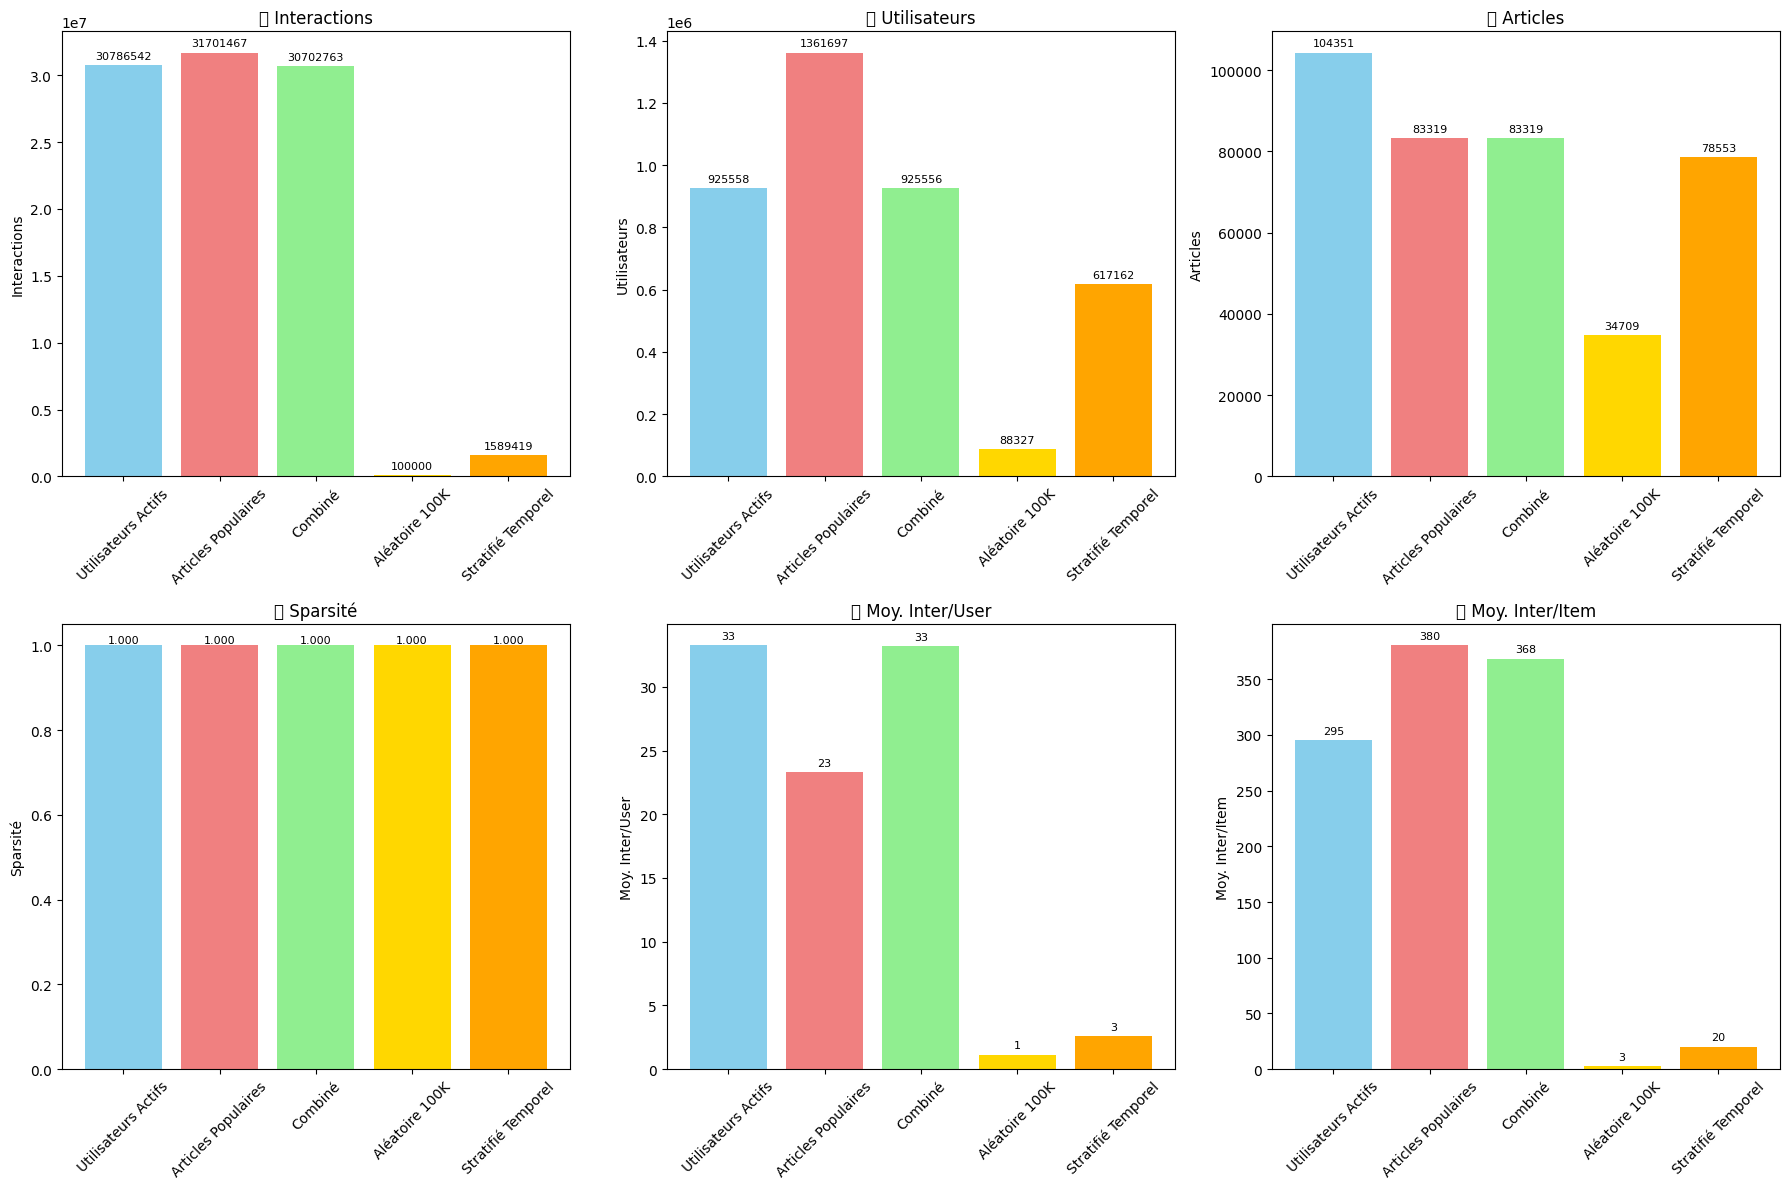

In [ ]:


fig, axes = plt.subplots(2, 3, figsize=(18, 12))

metrics = ['n_interactions', 'n_users', 'n_items', 'sparsity', 'avg_inter_user', 'avg_inter_item']
titles = ['Interactions', 'Utilisateurs', 'Articles', 'Sparsité', 'Moy. Inter/User', 'Moy. Inter/Item']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i//3, i%3]
    values = comparison_df[metric]
    bars = ax.bar(comparison_df.index, values,
                  color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'orange'])
    ax.set_title(f'📊 {title}')
    ax.set_ylabel(title)
    ax.tick_params(axis='x', rotation=45)

    # Annotations
    for bar, val in zip(bars, values):
        if metric == 'sparsity':
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{val:.3f}', ha='center', va='bottom', fontsize=8)
        else:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                   f'{val:.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(f"{OUTPUTS_PATH}/figures/sampling_strategies_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

## 📏 CRÉATION D'ÉCHANTILLONS DE DIFFÉRENTES TAILLES



📏 CRÉATION D'ÉCHANTILLONS DE TAILLES VARIÉES
📊 Échantillon de base: 30,702,763 interactions
✅ Échantillon 1K créé
✅ Échantillon 5K créé
✅ Échantillon 10K créé
✅ Échantillon 50K créé
✅ Échantillon 100K créé

📊 COMPARAISON PAR TAILLE:
             n_users  n_items  n_interactions  sparsity  avg_inter_user  \
Sample_1K      998.0    966.0          1000.0       1.0            1.00   
Sample_5K     4952.0   4328.0          5000.0       1.0            1.01   
Sample_10K    9848.0   7837.0         10000.0       1.0            1.02   
Sample_50K   46716.0  24154.0         50000.0       1.0            1.07   
Sample_100K  87794.0  34601.0        100000.0       1.0            1.14   

             avg_inter_item  
Sample_1K              1.04  
Sample_5K              1.16  
Sample_10K             1.28  
Sample_50K             2.07  
Sample_100K            2.89  


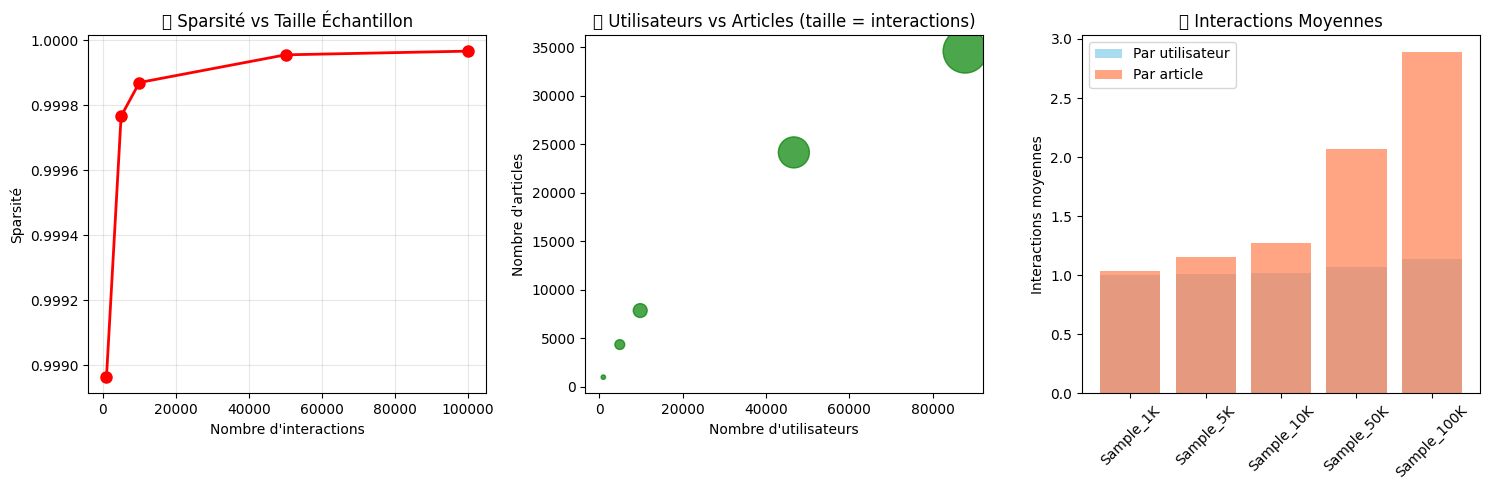

In [ ]:
print("\n" + "="*60)
print("📏 CRÉATION D'ÉCHANTILLONS DE TAILLES VARIÉES")
print("="*60)

# Utilisation de la stratégie combinée (la plus équilibrée)
base_sample = sample_combine.copy()
print(f"📊 Échantillon de base: {len(base_sample):,} interactions")

sample_sizes = [1000, 5000, 10000, 50000, 100000]
size_samples = {}

for size in sample_sizes:
    if len(base_sample) >= size:
        sample = base_sample.sample(n=size, random_state=42)
        size_samples[f'Sample_{size//1000}K'] = {
            'data': sample,
            'stats': calculer_stats_echantillon(sample)
        }
        print(f"✅ Échantillon {size//1000}K créé")
    else:
        print(f"❌ Échantillon {size//1000}K impossible (données insuffisantes)")

# Comparaison des tailles
size_stats = pd.DataFrame({k: v['stats'] for k, v in size_samples.items()}).T
print("\n📊 COMPARAISON PAR TAILLE:")
print(size_stats.round(2))

# Visualisation impact taille
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sparsité vs Taille
axes[0].plot(size_stats['n_interactions'], size_stats['sparsity'], 'o-', color='red', linewidth=2, markersize=8)
axes[0].set_xlabel('Nombre d\'interactions')
axes[0].set_ylabel('Sparsité')
axes[0].set_title('📉 Sparsité vs Taille Échantillon')
axes[0].grid(True, alpha=0.3)

# Utilisateurs vs Articles
axes[1].scatter(size_stats['n_users'], size_stats['n_items'],
               s=size_stats['n_interactions']/100, alpha=0.7, color='green')
axes[1].set_xlabel('Nombre d\'utilisateurs')
axes[1].set_ylabel('Nombre d\'articles')
axes[1].set_title('👥 Utilisateurs vs Articles (taille = interactions)')

# Interactions moyennes
x = range(len(size_stats))
axes[2].bar(x, size_stats['avg_inter_user'], alpha=0.7, label='Par utilisateur', color='skyblue')
axes[2].bar(x, size_stats['avg_inter_item'], alpha=0.7, label='Par article', color='coral')
axes[2].set_xticks(x)
axes[2].set_xticklabels(size_stats.index, rotation=45)
axes[2].set_ylabel('Interactions moyennes')
axes[2].set_title('📊 Interactions Moyennes')
axes[2].legend()

plt.tight_layout()
plt.savefig(f"{OUTPUTS_PATH}/figures/sample_sizes_analysis.png", dpi=300, bbox_inches='tight')
plt.show()


## 🎯 SÉLECTION DE L'ÉCHANTILLON OPTIMAL


In [ ]:
print("\n" + "="*60)
print("🎯 SÉLECTION DE L'ÉCHANTILLON OPTIMAL")
print("="*60)

# Critères de sélection
def scorer_echantillon(stats):
    """Score un échantillon selon plusieurs critères"""
    score = 0

    # Taille raisonnable (10K-50K optimal)
    if 10000 <= stats['n_interactions'] <= 50000:
        score += 3
    elif stats['n_interactions'] < 10000:
        score += 1

    # Sparsité pas trop élevée
    if stats['sparsity'] < 0.98:
        score += 2
    elif stats['sparsity'] < 0.99:
        score += 1

    # Interactions par utilisateur raisonnables
    if 3 <= stats['avg_inter_user'] <= 10:
        score += 2
    elif stats['avg_inter_user'] >= 2:
        score += 1

    return score

# Évaluation des échantillons
scores = {}
for name, sample_info in size_samples.items():
    score = scorer_echantillon(sample_info['stats'])
    scores[name] = score
    print(f"📊 {name}: Score = {score}/7")

# Sélection du meilleur
best_sample_name = max(scores.keys(), key=lambda x: scores[x])
best_sample = size_samples[best_sample_name]

print(f"\n🏆 ÉCHANTILLON OPTIMAL SÉLECTIONNÉ: {best_sample_name}")
print(f"   • Interactions: {best_sample['stats']['n_interactions']:,}")
print(f"   • Utilisateurs: {best_sample['stats']['n_users']:,}")
print(f"   • Articles: {best_sample['stats']['n_items']:,}")
print(f"   • Sparsité: {best_sample['stats']['sparsity']:.3f}")


🎯 SÉLECTION DE L'ÉCHANTILLON OPTIMAL
📊 Sample_1K: Score = 1/7
📊 Sample_5K: Score = 1/7
📊 Sample_10K: Score = 3/7
📊 Sample_50K: Score = 3/7
📊 Sample_100K: Score = 0/7

🏆 ÉCHANTILLON OPTIMAL SÉLECTIONNÉ: Sample_10K
   • Interactions: 10,000
   • Utilisateurs: 9,848
   • Articles: 7,837
   • Sparsité: 1.000


## 💾 SAUVEGARDE DES ÉCHANTILLONS


In [ ]:
print("\n💾 Sauvegarde des échantillons...")

# Échantillon principal pour développement
echantillon_principal = best_sample['data'].copy()

# Échantillon réduit pour tests rapides
echantillon_test = size_samples['Sample_1K']['data'] if 'Sample_1K' in size_samples else echantillon_principal.sample(1000, random_state=42)

# Préparation des données de sortie
sampling_results = {
    'echantillon_principal': {
        'data': echantillon_principal,
        'stats': best_sample['stats'],
        'description': f"Échantillon principal ({best_sample_name}) pour développement"
    },
    'echantillon_test': {
        'data': echantillon_test,
        'stats': calculer_stats_echantillon(echantillon_test),
        'description': "Petit échantillon pour tests rapides"
    },
    'strategies_comparison': comparison_df,
    'size_analysis': size_stats,
    'sampling_metadata': {
        'date_creation': datetime.now().isoformat(),
        'strategie_selectionnee': 'Utilisateurs actifs + Articles populaires',
        'criteres_selection': ['Taille optimale', 'Sparsité raisonnable', 'Distribution équilibrée'],
        'recommandations': [
            "Utiliser échantillon principal pour développement",
            "Utiliser échantillon test pour itérations rapides",
            "Valider sur données complètes en fin de développement"
        ]
    }
}

# Sauvegarde
with open(f"{OUTPUTS_PATH}/sampling_results.pkl", "wb") as f:
    pickle.dump(sampling_results, f)

# Sauvegarde CSV pour inspection
echantillon_principal.to_csv(f"{OUTPUTS_PATH}/samples/echantillon_principal.csv", index=False)
echantillon_test.to_csv(f"{OUTPUTS_PATH}/samples/echantillon_test.csv", index=False)

print(f"✅ Échantillons sauvegardés:")
print(f"   • Principal: {len(echantillon_principal):,} interactions")
print(f"   • Test: {len(echantillon_test):,} interactions")
print(f"   • Métadonnées: sampling_results.pkl")


💾 Sauvegarde des échantillons...
✅ Échantillons sauvegardés:
   • Principal: 10,000 interactions
   • Test: 1,000 interactions
   • Métadonnées: sampling_results.pkl


## 📋 RECOMMANDATIONS FINALES


In [ ]:
print("\n" + "="*70)
print("🎯 RECOMMANDATIONS POUR LA SUITE")
print("="*70)

print(f"\n📊 ÉCHANTILLON SÉLECTIONNÉ:")
print(f"   • {len(echantillon_principal):,} interactions")
print(f"   • {echantillon_principal['customer_id'].nunique():,} utilisateurs uniques")
print(f"   • {echantillon_principal['article_id'].nunique():,} articles uniques")
print(f"   • Sparsité: {best_sample['stats']['sparsity']:.3f}")

print(f"\n🎯 AVANTAGES DE CET ÉCHANTILLON:")
print(f"   • Utilisateurs actifs (≥5 interactions) → Moins de cold start")
print(f"   • Articles populaires (≥10 interactions) → Patterns plus clairs")
print(f"   • Taille optimale pour expérimentation rapide")
print(f"   • Préserve les caractéristiques du dataset original")

print(f"\n🚀 PROCHAINES ÉTAPES:")
print(f"   1. Préprocessing (mappings entiers, matrice sparse)")
print(f"   2. Train/test split temporel")
print(f"   3. Premier modèle LightFM sur échantillon")
print(f"   4. Validation sur données complètes si satisfaisant")

print("\n✅ Échantillonnage terminé - Prêt pour le preprocessing!")
print("="*70)


🎯 RECOMMANDATIONS POUR LA SUITE

📊 ÉCHANTILLON SÉLECTIONNÉ:
   • 10,000 interactions
   • 9,848 utilisateurs uniques
   • 7,837 articles uniques
   • Sparsité: 1.000

🎯 AVANTAGES DE CET ÉCHANTILLON:
   • Utilisateurs actifs (≥5 interactions) → Moins de cold start
   • Articles populaires (≥10 interactions) → Patterns plus clairs
   • Taille optimale pour expérimentation rapide
   • Préserve les caractéristiques du dataset original

🚀 PROCHAINES ÉTAPES:
   1. Préprocessing (mappings entiers, matrice sparse)
   2. Train/test split temporel
   3. Premier modèle LightFM sur échantillon
   4. Validation sur données complètes si satisfaisant

✅ Échantillonnage terminé - Prêt pour le preprocessing!
